# KLNX methodology (synthetic dataset)

## Import libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np

# Ploting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import graphviz

# Scikit learn support functions
from sklearn.manifold import MDS
from sklearn import mixture
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Scikit learn models
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Miscoding libraries
from nescience.miscoding import Miscoding
from nescience.classifier import Classifier

sn.set_theme()

## Load dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p                         20000 non-null  float64
 1   RTT                       20000 non-null  float64
 2   MSS                       20000 non-null  float64
 3   CWIN                      20000 non-null  float64
 4   End.RSSI.dBm              20000 non-null  float64
 5   End.RSRP.dBm              20000 non-null  float64
 6   End.SINR.dB               20000 non-null  float64
 7   Start.RSSI.dBm            20000 non-null  float64
 8   Start.RSRP.dBm            20000 non-null  float64
 9   Start.SINR.dB             20000 non-null  float64
 10  Synth.Session.Duration.s  20000 non-null  float64
dtypes: float64(11)
memory usage: 1.7 MB


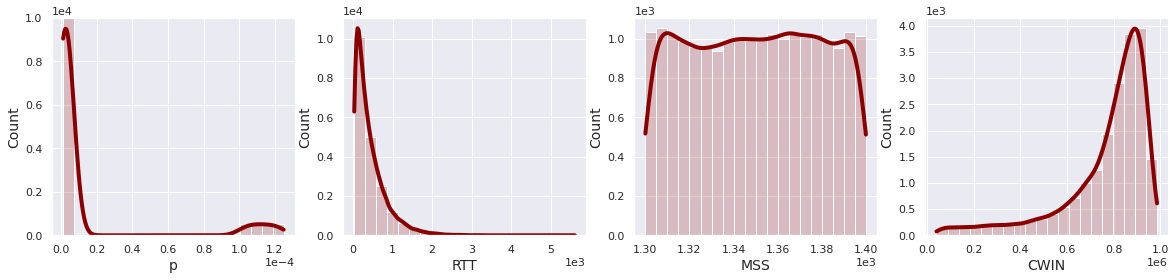

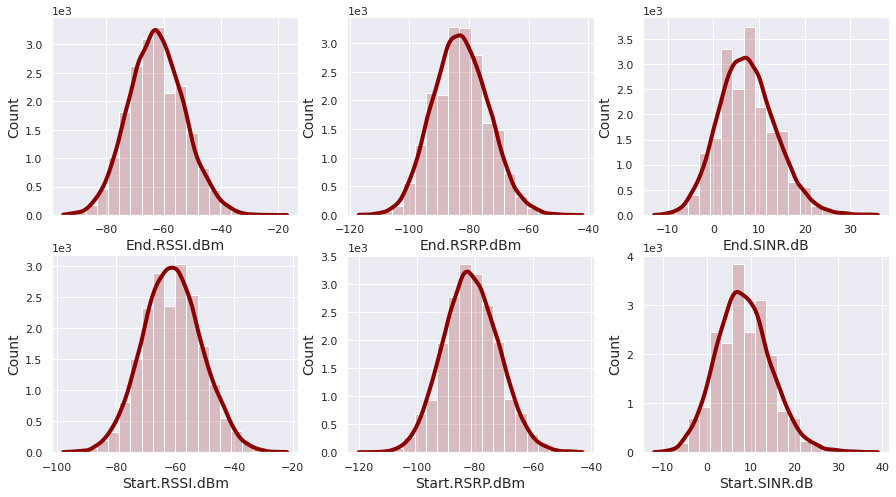

In [2]:
data = pd.read_csv("data/synthetic_dataset.csv", sep=",")
data = data.drop(['Unnamed: 0'], axis=1).copy()
data.info()

indicators = data[['p','RTT','MSS','CWIN']].copy()
n_hbins = 20
fig = plt.figure(figsize=(20,4))
ii = 1
for col in indicators.columns:
    axes = fig.add_subplot(1,4,ii)
    sn.histplot(indicators[col], 
                bins=n_hbins,
                color='darkred',
                alpha = 0.20,
                kde=True, 
                ax=axes, 
                line_kws={'lw':4})
    if(col=='p'):
        axes.set_ylim(0,10000)
    axes.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    axes.xaxis.label.set_size(14)
    axes.yaxis.label.set_size(14)
    ii += 1
plt.savefig('images/indicators_kde.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

radio_indicators = data.drop(['p','RTT','MSS','CWIN','Synth.Session.Duration.s'], axis=1).copy()
n_hbins = 20
fig = plt.figure(figsize=(15,8))
ii = 1
for col in radio_indicators.columns:
    axes = fig.add_subplot(2,3,ii)
    sn.histplot(radio_indicators[col], 
                bins=n_hbins,
                color='darkred',
                alpha = 0.20,
                kde=True, 
                ax=axes, 
                line_kws={'lw':4})
    axes.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    axes.xaxis.label.set_size(14)
    axes.yaxis.label.set_size(14)
    ii += 1
plt.savefig('images/radio_indicators_kde.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

## Training set preparation

### Discards experiments with a large number of outliers

In [3]:
# Discard rows with high number of outliers (This dataset shall be used to TRAIN the decision tree)
data["N_outlier"] = 0
for col in data.columns:
    data_nrm = data[col]/data[col].std()
    Q3 = data_nrm.quantile(0.75) - data_nrm.median()
    med = data[col].median()
    dev = data[col] - med
    MAD = (1/Q3) * dev.abs().median()
    if (MAD != 0):
        data.loc[(data[col]<= med - (3 * MAD)) | (data[col]>= med + (3 * MAD)), 'N_outlier'] += 1    
data_non_outliers = data.loc[data["N_outlier"] == 0].drop("N_outlier", axis=1)
data = data.drop("N_outlier", axis=1)
data_non_outliers.shape

/tmp/ipykernel_36045/645007468.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  MAD = (1/Q3) * dev.abs().median()
/tmp/ipykernel_36045/645007468.py:8: RuntimeWarning: invalid value encountered in double_scalars
  MAD = (1/Q3) * dev.abs().median()


(15883, 11)

### Feature selection based on model-based clustering

In [4]:
corr_matrix = 1 - data_non_outliers.corr(method="pearson").abs()
transformed_samples = MDS(n_components=2, dissimilarity='euclidean', random_state=42).fit_transform(np.transpose(data_non_outliers))

lowest_bic = np.infty
bic = []
n_components_range = range(1, 6)
for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(transformed_samples)
    bic.append(gmm.bic(transformed_samples))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

bic = np.array(bic)
clf = best_gmm
classification_non_out = clf.predict(transformed_samples)
centroids_non_out = clf.means_

closest_non_out = [pairwise_distances_argmin_min(centroids_non_out[:][int(n_class)].reshape(1, -1), transformed_samples[np.where(classification_non_out == n_class)])[0] for n_class in np.unique(classification_non_out)]
corr_columns_non_out = np.array(corr_matrix.columns.values)
final_cols_non_out = [corr_columns_non_out[np.where(classification_non_out == n_class)][int(closest_non_out[index])] for index, n_class in enumerate(np.unique(classification_non_out))]
final_cols_non_out = np.delete(final_cols_non_out, classification_non_out[len(classification_non_out)-1])

### KPI discretization

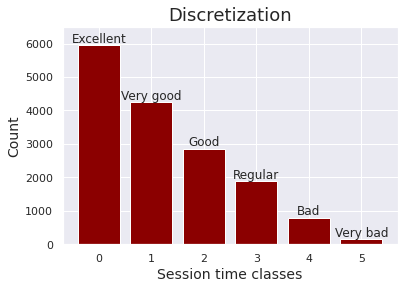

In [5]:
y_train = data_non_outliers['Synth.Session.Duration.s'].values
y_train = y_train.reshape(-1, 1)
n_bins = int(np.log2(len(y_train))/2)

disc_model = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
disc_model.fit(y_train)
yd = disc_model.transform(y_train)
yd = yd[:,0]

val, count = np.unique(yd, return_counts=True)
labels = ['Excellent','Very good', 'Good', 'Regular', 'Bad', 'Very bad']
plt.bar(x=val, height=count, color='darkred')
plt.xlabel("Session time classes", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.ylim(0,6500)
plt.title('Discretization', fontsize=18)
for ii in range(len(val)):
    plt.text(val[ii],count[ii]+80,labels[ii],horizontalalignment='center', fontsize=12)
plt.savefig('images/discretization_syntheticdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

### Knowledge model training

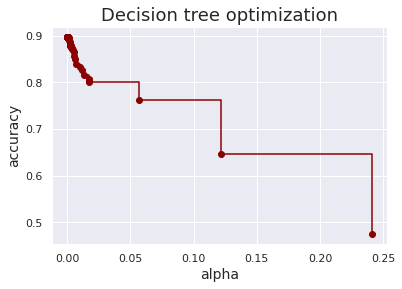

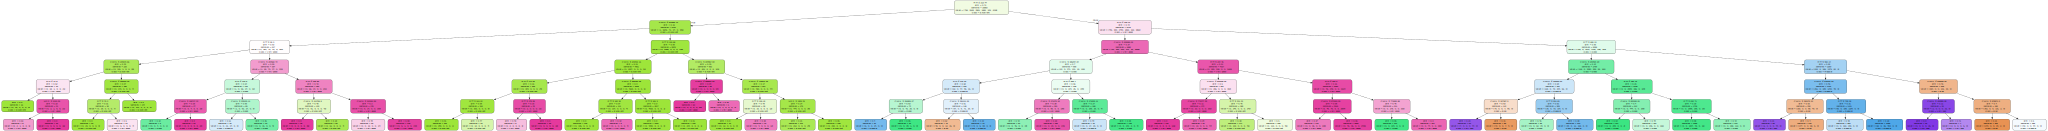

In [6]:
X_train = data_non_outliers[final_cols_non_out].copy()
depth = int(np.log2(len(y_train))/2)
clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5)
path = clf.cost_complexity_pruning_path(X_train, yd)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=ccp_alpha)
    clf.fit(X_train, yd)
    clfs.append(clf)
scores = [cross_val_score(clf, X_train, yd, cv=30, n_jobs=-1).mean() for clf in clfs]

plt.figure()
plt.plot(ccp_alphas, scores, marker='o', drawstyle="steps-post", color='darkred')
plt.xlabel("alpha", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
plt.title("Decision tree optimization", fontsize=18)
plt.savefig('images/model1_optimization_synteticdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

best_alpha = ccp_alphas[np.where(scores == np.max(scores))[0][0]]
len(ccp_alphas), np.where(scores == np.max(scores))[0][0], best_alpha
knowledge = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=best_alpha)
knowledge.fit(X_train, yd)

bins = disc_model.bin_edges_[0].tolist()
labels = ['Excellent','Very good', 'Good', 'Regular', 'Bad', 'Very bad']
data1= pd.cut(x=y_train.reshape(-1), bins = bins, labels=labels, include_lowest=True)
knowledge_label = DecisionTreeClassifier(max_depth=n_bins, min_samples_leaf=5, ccp_alpha=best_alpha)
knowledge_label.fit(X_train, data1)

dot_data = tree.export_graphviz(knowledge_label, 
                                feature_names = np.array(X_train.columns), 
                                class_names=knowledge_label.classes_, 
                                filled=True, 
                                rounded=True, 
                                out_file=None,
                                precision=2,
                                special_characters=True)

graph = graphviz.Source(dot_data)
#graph.format='eps'
graph.format='png'
filename = graph.render(filename='models/model1_syntheticdata')
graph

## Feature selection based on the miscoding metric

### Vector of anomalous scenarios

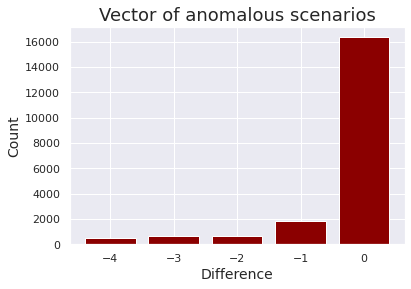

In [7]:
y = data['Synth.Session.Duration.s'].values
y = y.reshape(-1, 1)
ydt = disc_model.transform(y)
ydt = ydt[:,0]
y_pred = knowledge.predict(data[final_cols_non_out])
y_diff = y_pred-ydt
y_diff[y_diff > 0] = 0
data["Diff_Pred"] = y_diff

val, count = np.unique(y_diff, return_counts=True)
plt.bar(x=val, height=count, color='darkred')
plt.ylabel("Count", fontsize=14)
plt.xlabel("Difference", fontsize=14)
plt.title("Vector of anomalous scenarios", fontsize=18)
plt.savefig('images/Vanm_syntheticdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

### Miscoding

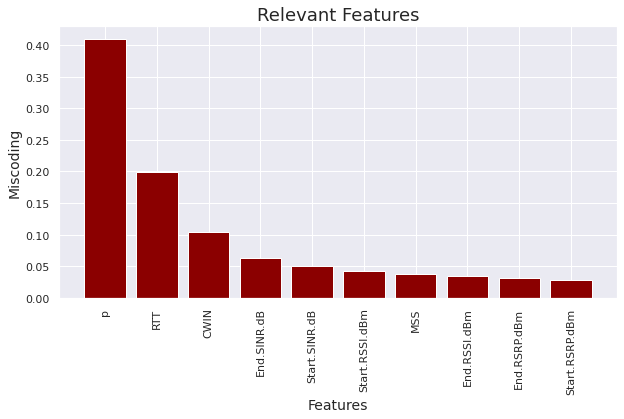

In [8]:
data_misc = data.drop(columns =['Synth.Session.Duration.s', "Diff_Pred"])
column_names = np.array(data_misc.columns)
n_clusters  = int(np.log2(len(data.index))/2)
n_features = min(n_clusters * n_clusters, len(data_misc.columns))
miscoding = Miscoding(redundancy=True)
miscoding.fit(data_misc, data["Diff_Pred"])
mscd = miscoding.miscoding_features()

plt.figure(figsize=(10,5))
plt.bar(x=np.arange(0, len(np.argsort(-mscd)[0:n_features])), height=mscd[np.argsort(-mscd)[0:n_features]], color='darkred')
plt.xticks(np.arange(0, len(np.argsort(-mscd)[0:n_features])), column_names[np.argsort(-mscd)[0:n_features]], rotation='vertical')
plt.xlabel("Features", fontsize=14)
plt.ylabel("Miscoding", fontsize=14)
plt.title("Relevant Features", fontsize=18)
plt.savefig('images/miscoding_syntheticdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()

best_mscd = np.argsort(-mscd)[0:n_features]
best_mscd = best_mscd[best_mscd != 15]
attributes = column_names[best_mscd]

## Identification of problematic attributes and experiments

-------------------------------------------
Selection of problematic attributes
Anomaly desity: -0.3550. Threshold: -0.7101.
-------------------------------------------
  Attribute  best_model  Class_1  Class_2
0         p  best_model  0.10330  0.89670
1       RTT  best_model  0.03235  0.96765


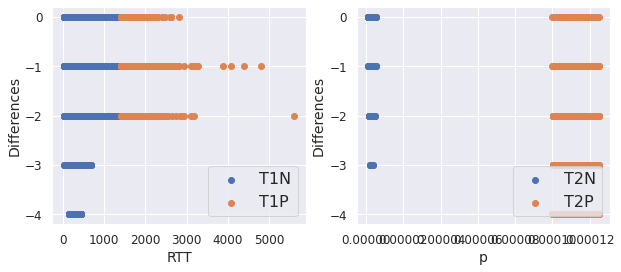

In [9]:
models = pd.DataFrame({"Attribute":pd.Series(dtype='str'),
                        "best_model":pd.Series(dtype='str'),
                        "Class_1":pd.Series(dtype='float'),
                        "Class_2":pd.Series(dtype='float')})
threshold = 2.00 * y_diff.mean()
k=0
print('-------------------------------------------')
print('Selection of problematic attributes')
print('Anomaly desity: %.4f. Threshold: %.4f.'%(y_diff.mean(), threshold))
print('-------------------------------------------')
for i in range(len(attributes)):
    #print(attributes[i])
    attr = data[attributes[i]]
    scaler = StandardScaler()
    scaler.fit(attr.values.reshape(-1, 1))
    data2prc = scaler.transform(attr.values.reshape(-1, 1))

    cov_type = "full"
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 5)
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=584)
        gmm.fit(data2prc)
        bic.append(gmm.bic(data2prc))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    bic = np.array(bic)
    clf = best_gmm
    clustering = clf.predict(data2prc)
    classes = np.unique(clustering)
    class_problem = np.zeros(clustering.shape)
    
    if (classes.shape[0] > 1):
        for ii in range(classes.shape[0]):
            ratio = y_diff[clustering==classes[ii]].mean()
            #print(ratio)
            if ((ratio <= threshold) & (clustering[clustering==classes[ii]].shape[0] > 0.01*clustering.shape[0])):
                class_problem[clustering==classes[ii]]=1
            else:
                class_problem[clustering==classes[ii]]=2
        problem_classes = np.unique(class_problem)
        if (problem_classes.shape[0] > 1):
            if (k==0):
                cls_mat = class_problem.reshape(-1,1)
            else:
                cls_mat= np.hstack((cls_mat, class_problem.reshape(-1,1)))
            k=k+1            
            counts = np.array([class_problem[class_problem==1].shape[0], class_problem[class_problem==2].shape[0]])
            total  = np.sum(counts)
            models = models.append({'Attribute':attributes[i],
                                    'best_model':'best_model',
                                    'Class_1':counts[0]/total,
                                    'Class_2':counts[1]/total},ignore_index=True)
print(models)      


attributes = models["Attribute"].values
attributes, att_ind = np.unique(attributes, return_index=True)
cls_mat = cls_mat[:,att_ind]


nfig = attributes.shape[0]
ncol = 2
nrow = (nfig//ncol) + 1

fig = plt.figure(figsize=(10,4))
k = 0;
for attr in attributes:
    cls_vec = cls_mat[:,k]
    bl_vec1 = (cls_vec==1)
    bl_vec2 = (cls_vec==2)
    
    axes = fig.add_subplot(1,2,k+1)
    plt.scatter(data[attr][bl_vec2], data["Diff_Pred"][bl_vec2], label='T%dN'%(k+1))
    plt.scatter(data[attr][bl_vec1], data["Diff_Pred"][bl_vec1], label='T%dP'%(k+1))
    plt.legend(fontsize=16, loc='lower right' )

    
    plt.xlabel(attr, fontsize=14)
    plt.ylabel("Differences", fontsize=14)
    plt.yticks([-4, -3, -2, -1, 0], fontsize=12)
    plt.xticks(fontsize=12)
    k = k+1

plt.savefig('images/prob_identification_syntheticdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()    

## Buildind the anomaly classification model

### Generate the classification labels

In [10]:
problem = np.empty(cls_mat.shape[0], dtype=object)
separator = ';'
for ii in range(cls_mat.shape[0]):    
    strings = []
    for jj in range(cls_mat.shape[1]):
        if (cls_mat[ii,jj] == 1):
            strings = strings + ['T%dP'%(jj+1)]
        if (cls_mat[ii,jj] == 2):
            strings = strings + ['T%dN'%(jj+1)]
    problem[ii] = separator.join(strings)  

### Classification model training

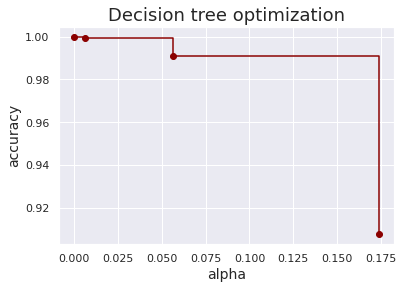

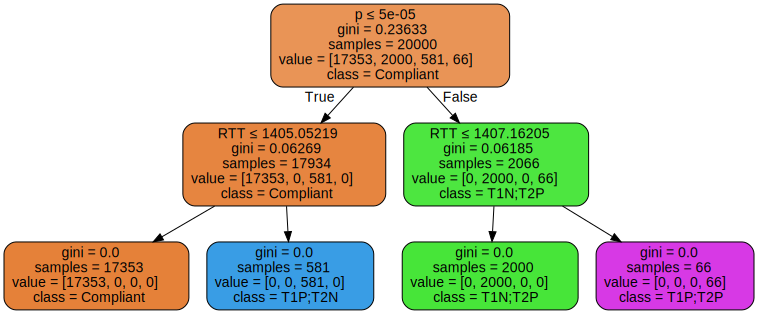

In [11]:
X = data.copy()
X['Problem'] = problem
X.loc[X.Problem.str.contains('^[^P]+$'), "Problem"] = "Compliant"    
fX = X.copy()
fy = fX["Problem"]
fX = fX.drop(["Problem", "Diff_Pred"], axis=1)
depth = int(np.log2(np.sum(fy != "Compliant"))/2)

clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5)
path = clf.cost_complexity_pruning_path(fX, fy)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=ccp_alpha)
    clf.fit(fX, fy)
    clfs.append(clf)
scores = [cross_val_score(clf, fX, fy, cv=5, n_jobs=-1).mean() for clf in clfs]

plt.figure()
plt.plot(ccp_alphas, scores, marker='o', drawstyle="steps-post", color='darkred')
plt.xlabel("alpha", fontsize=14)
plt.ylabel("accuracy", fontsize=14)
plt.title("Decision tree optimization", fontsize=18)
plt.savefig('images/model2_optimization_syntheticdata.png', bbox_inches='tight', pad_inches=0, dpi=600)
plt.show()


best_alpha = ccp_alphas[np.where(scores == np.max(scores))[0][0]]
len(ccp_alphas), np.where(scores == np.max(scores))[0][0], best_alpha
classifier = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=best_alpha)
classifier.fit(fX, fy)

dot_data = tree.export_graphviz(classifier, 
                                feature_names = np.array(fX.columns), 
                                class_names=classifier.classes_, 
                                filled=True, 
                                rounded=True, 
                                out_file=None,
                                precision=5,
                                special_characters=True)

graph = graphviz.Source(dot_data)
#graph.format='eps'
graph.format='png'
filename = graph.render(filename='models/model2_syntheticdata')
graph